In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from knn_colors import knn_fit, getTrueY

In [2]:
unp = Table.read("unperturbed_mags.fits")

In [3]:
unp.info

<Table length=698211>
       name         dtype  unit    class     n_bad
------------------ ------- ---- ------------ -----
                ID   int64      MaskedColumn     0
                RA float64  deg       Column     0
               DEC float64  deg       Column     0
        ID_CLASSIC   int64      MaskedColumn     1
            photoz float64            Column     0
           lp_type   int64      MaskedColumn     0
         lp_NbFilt   int64      MaskedColumn     0
             lp_zq float64            Column     0
          lp_model   int64      MaskedColumn     0
            lp_age float64            Column     0
           lp_dust float64            Column     0
    lp_Attenuation   int64      MaskedColumn     0
       lp_mass_med float64            Column     0
      lp_mass_best float64            Column     0
        lp_SFR_med float64            Column     0
       lp_SFR_best float64      MaskedColumn   511
       lp_sSFR_med float64      MaskedColumn    23
      lp_

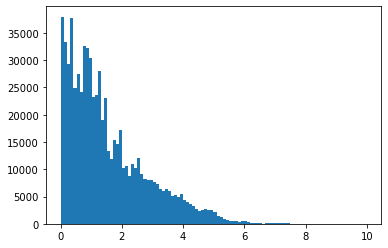

In [4]:
plt.hist(unp["photoz"], bins=100)
plt.show()

In [3]:
mock = Table.read("ext_phot.fits")
mask = unp["Euclid_VIS_MAG"] <= 24.5

In [4]:
# lets do some photo-z fitting using knn method
# use unperturbed catalog as training set
# split in half so half the objects are for training, and half for test

train = unp[mask]
test = mock[mask]

rng = np.random.default_rng(seed=42)
random_ids = np.arange(len(train))
rng.shuffle(random_ids)
split_dex = int(len(train) / 2)

train = train[random_ids[0:split_dex]]
test = test[random_ids[split_dex:]]

print(len(test))

58221


In [5]:
# LSST griz and Euclid JH
mag_columns = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "Euclid_J_MAG", "Euclid_H_MAG"]

estz = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns, y_col_name="photoz")
truez = getTrueY(test_cat=test, mag_col_names=mag_columns, y_col_name="photoz")

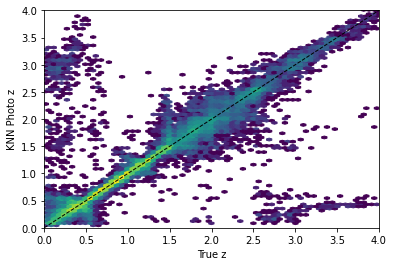

In [8]:
plt.hexbin(truez, estz, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [9]:
# define photo-z summary statistics

def sigma(z_est, z_true, N):
    numerator = (z_est - z_true)
    denominator = (1+z_true)
    summand = (numerator/denominator)**2
    summed = np.sum(summand)
    return 1/N * summed

def bias(z_est, z_true, N):
    summand = (z_est - z_true)
    summed = np.sum(summand)
    return 1/N * summed

def abs_bias(z_est, z_true, N):
    summand = np.abs(z_est - z_true)
    summed = np.sum(summand)
    return 1/N * summed

In [10]:
sig = sigma(estz, truez, len(estz))

b = bias(estz, truez, len(estz))

a_b = abs_bias(estz, truez, len(estz))

In [11]:
good = np.abs(estz - truez) < 5*sig
bad = np.abs(estz - truez) > 5*sig

In [12]:
good

array([ True,  True,  True, ...,  True,  True,  True])

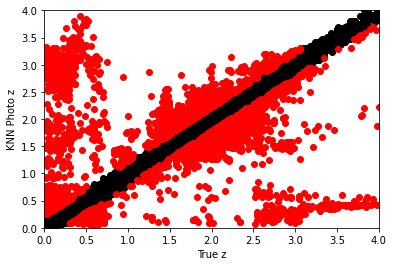

In [13]:
plt.scatter(truez[good], estz[good], color = 'k')
plt.scatter(truez[bad], estz[bad], color = 'r')

plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [14]:
np.shape(truez[good])

(54196,)

In [6]:
# LSST + CASTOR 
mag_columns_castor_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "castor_uv_MAG", "castor_u_MAG", "castor_g_MAG"]

estz_LSST_Castor = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")
truez_LSST_Castor = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")

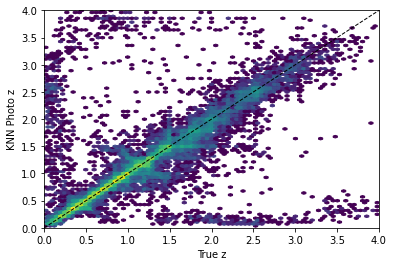

In [7]:
plt.hexbin(truez_LSST_Castor, estz_LSST_Castor, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [8]:
# LSST 
mag_columns_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG"]

estz_LSST = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="photoz")
truez_LSST = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="photoz")

In [9]:
LSST_g_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=test, mag_col_names=mag_columns_LSST, y_col_name="LSST_z_MAG")

In [11]:
data_array_LSST = np.array([np.abs(truez_LSST - estz_LSST), LSST_g_mag, LSST_r_mag, LSST_i_mag, LSST_z_mag])

data_array_sorted_LSST = data_array_LSST.T[data_array_LSST[0,:].argsort()] # no idea why this works the way it does...

In [14]:
# now make the sorted color arrays

gminusr_LSST = data_array_sorted_LSST[:,1] - data_array_sorted_LSST[:,2]
rminusi_LSST = data_array_sorted_LSST[:,2] - data_array_sorted_LSST[:,3]
iminusz_LSST = data_array_sorted_LSST[:,3] - data_array_sorted_LSST[:,4]

In [21]:
len(gminusr)/10

5821.7

In [22]:
gminusr[-5821:]

array([1.57798846, 0.16620682, 0.14709481, ..., 1.21078844, 5.57419522,
       1.50911384])

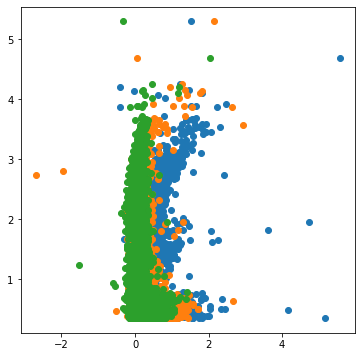

In [15]:

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

plt.scatter(gminusr_LSST[-5821:], data_array_sorted_LSST[-5821:, 0])
plt.scatter(rminusi_LSST[-5821:], data_array_sorted_LSST[-5821:, 0])
plt.scatter(iminusz_LSST[-5821:], data_array_sorted_LSST[-5821:, 0])

In [26]:
# fig, ax = plt.subplots(1, 2, figsize = (15,10))

# sc1 = ax[0].scatter(gminusr[-5821:],rminusi[-5821:], c=data_array_sorted[-5821:, 0], cmap=plt.cm.jet)
# # cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

# ax[0].set_xlabel('g-r', fontsize = 24)
# ax[0].set_ylabel('r-i', fontsize = 24)
# ax[0].set_title('LSST only', fontsize = 24)

# sc2 = ax[1].scatter(gminusr[-5821:],rminusi[-5821:], c=data_array_sorted[-5821:, 0], cmap=plt.cm.jet)
# # cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

# ax[1].set_xlabel('g-r', fontsize = 24)
# ax[1].set_ylabel('r-i', fontsize = 24)
# ax[1].set_title('LSST + CASTOR', fontsize = 24)

# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])

# fig.colorbar(sc1, cax=cbar_ax, label = 'Absolute Error in Inferred Redshift')

In [27]:
?plt.figure

Text(0.5, 1.0, 'LSST only')

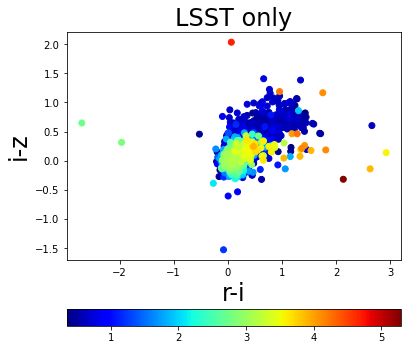

In [16]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

sc = plt.scatter(rminusi_LSST[-5821:],iminusz_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 0], cmap=plt.cm.jet)
cbar = fig.colorbar(sc, orientation='horizontal')    

plt.xlabel('r-i', fontsize = 24)
plt.ylabel('i-z', fontsize = 24)
plt.title('LSST only', fontsize = 24)

In [17]:
mag_columns_castor_LSST = ["LSST_g_MAG", "LSST_r_MAG", "LSST_i_MAG", "LSST_z_MAG",
               "castor_uv_MAG", "castor_u_MAG", "castor_g_MAG"]

estz_LSST_Castor = knn_fit(train_cat=train, test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")
truez_LSST_Castor = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="photoz")

LSST_g_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_g_MAG")
LSST_r_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_r_MAG")
LSST_i_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_i_MAG")
LSST_z_mag_CASTOR = getTrueY(test_cat=test, mag_col_names=mag_columns_castor_LSST, y_col_name="LSST_z_MAG")

In [21]:
data_array_CASTOR = np.array([np.abs(truez_LSST_Castor - estz_LSST_Castor), LSST_g_mag_CASTOR, LSST_r_mag_CASTOR, LSST_i_mag_CASTOR, LSST_z_mag_CASTOR])

data_array_sorted_CASTOR = data_array_CASTOR.T[data_array_CASTOR[0,:].argsort()] # no idea why this works the way it does...

In [22]:
gminusr_CASTOR = data_array_sorted_CASTOR[:,1] - data_array_sorted_CASTOR[:,2]
rminusi_CASTOR = data_array_sorted_CASTOR[:,2] - data_array_sorted_CASTOR[:,3]
iminusz_CASTOR = data_array_sorted_CASTOR[:,3] - data_array_sorted_CASTOR[:,4]

Text(0.5, 1.0, 'LSST+CASTOR')

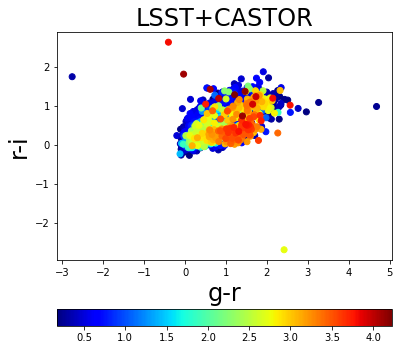

In [23]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

sc = plt.scatter(gminusr_CASTOR[-5822:],rminusi_CASTOR[-5822:], c=data_array_sorted_CASTOR[-5822:, 0], cmap=plt.cm.jet)
cbar = fig.colorbar(sc, orientation='horizontal')    

plt.xlabel('g-r', fontsize = 24)
plt.ylabel('r-i', fontsize = 24)
plt.title('LSST+CASTOR', fontsize = 24)

Text(0.5, 1.0, 'LSST + Castor')

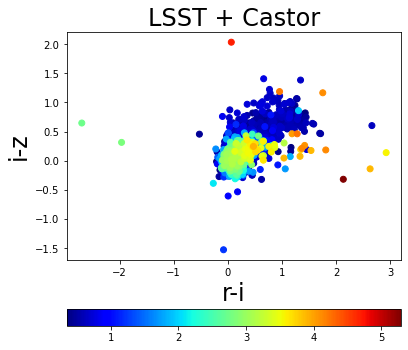

In [51]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

sc = plt.scatter(rminusi_CASTOR[-5822:],iminusz_CASTOR[-5822:], c=data_array_sorted_CASTOR[-5822:, 0], cmap=plt.cm.jet)
cbar = fig.colorbar(sc, orientation='horizontal')    

plt.xlabel('r-i', fontsize = 24)
plt.ylabel('i-z', fontsize = 24)
plt.title('LSST + Castor', fontsize = 24)

Text(0.5, 0.98, 'Top 10% in Absolute Redshift Error')

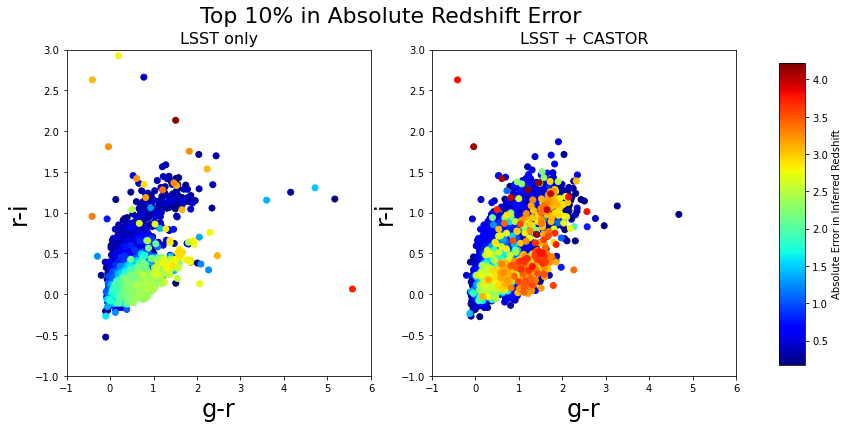

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(gminusr_LSST[-5821:],rminusi_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 0], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('g-r', fontsize = 24)
ax[0].set_ylabel('r-i', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(gminusr_CASTOR[-5821:],rminusi_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 0], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('g-r', fontsize = 24)
ax[1].set_ylabel('r-i', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc2, cax=cbar_ax, label = 'Absolute Error in Inferred Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

In [74]:
np.average(data_array_sorted_LSST[-200:,0]) #== np.median(np.abs(estz_LSST - truez_LSST))

3.1800985

In [73]:
np.average(data_array_sorted_CASTOR[-200:,0])# == np.median(np.abs(estz_LSST_Castor - truez_LSST_Castor))

3.28358425

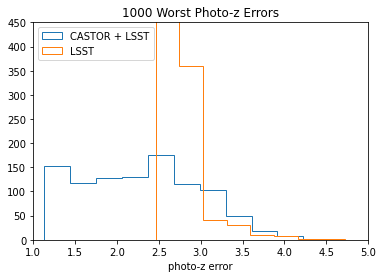

In [145]:
plt.title('1000 Worst Photo-z Errors')

plt.hist(data_array_sorted_CASTOR[-1000:,0], histtype = 'step', label = 'CASTOR + LSST')
plt.xlim(1, 5)
plt.ylim(0, 450)

plt.xlabel('photo-z error')

plt.hist(data_array_sorted_LSST[-1000:,0], histtype = 'step', label = 'LSST')
plt.xlim(1, 5)
plt.ylim(0, 450)

plt.xlabel('photo-z error')

plt.legend()

In [86]:
?plt.hist

Text(0.5, 0.98, 'Top 10% in Absolute Redshift Error')

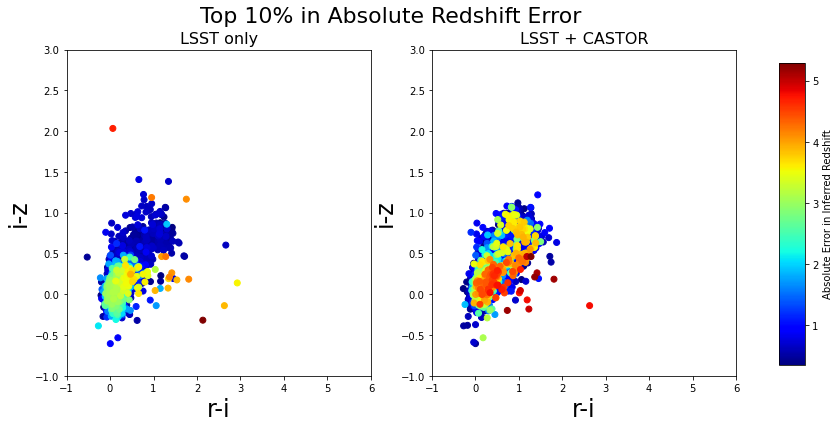

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(rminusi_LSST[-5821:],iminusz_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 0], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('r-i', fontsize = 24)
ax[0].set_ylabel('i-z', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(rminusi_CASTOR[-5821:],iminusz_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 0], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('r-i', fontsize = 24)
ax[1].set_ylabel('i-z', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'Absolute Error in Inferred Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

In [64]:
data_array_LSST = np.array([np.abs(truez_LSST - estz_LSST), LSST_g_mag, LSST_r_mag, LSST_i_mag, LSST_z_mag, truez_LSST])

data_array_sorted_LSST = data_array_LSST.T[data_array_LSST[0,:].argsort()] # no idea why this works the way it does...

data_array_CASTOR = np.array([np.abs(truez_LSST_Castor - estz_LSST_Castor), LSST_g_mag_CASTOR, LSST_r_mag_CASTOR, LSST_i_mag_CASTOR, LSST_z_mag_CASTOR, truez_LSST_Castor])

data_array_sorted_CASTOR = data_array_CASTOR.T[data_array_CASTOR[0,:].argsort()] # no idea why this works the way it does...

Text(0.5, 0.98, 'Top 10% in Absolute Redshift Error')

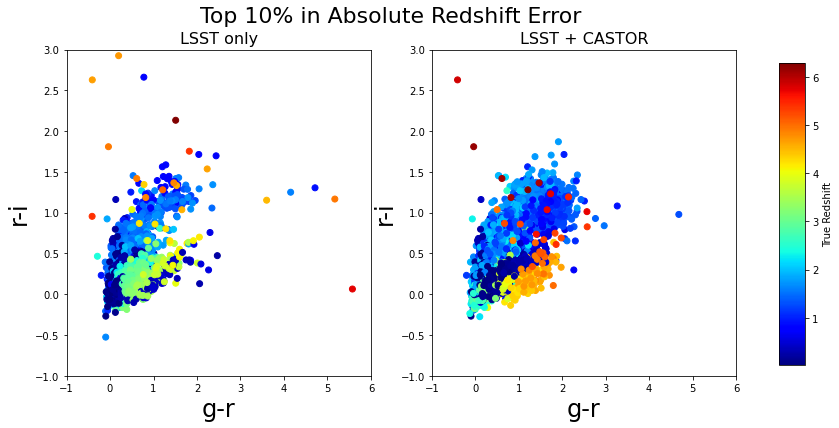

In [66]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(gminusr_LSST[-5821:],rminusi_LSST[-5821:], c=data_array_sorted_LSST[-5821:, 5], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('g-r', fontsize = 24)
ax[0].set_ylabel('r-i', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(gminusr_CASTOR[-5821:],rminusi_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 5], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('g-r', fontsize = 24)
ax[1].set_ylabel('r-i', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'True Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

Text(0.5, 0.98, 'Top 10% in Absolute Redshift Error')

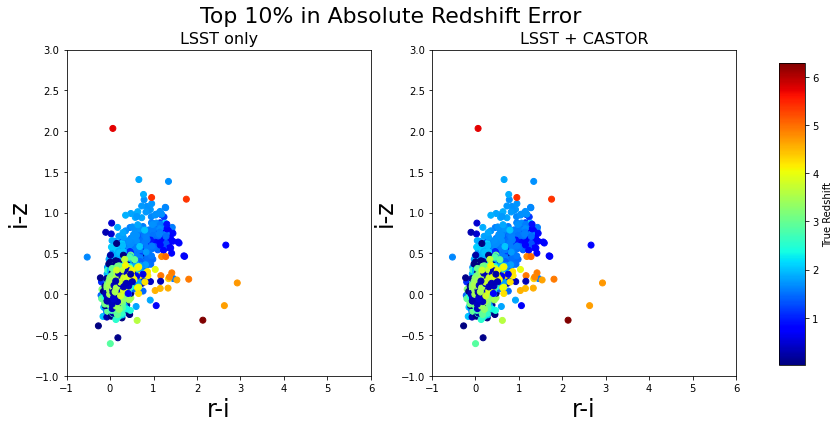

In [68]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

sc1 = ax[0].scatter(rminusi[-5821:],iminusz[-5821:], c=data_array_sorted[-5821:, 5], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc1, cax = ax[0], orientation='horizontal')    

ax[0].set_xlabel('r-i', fontsize = 24)
ax[0].set_ylabel('i-z', fontsize = 24)
ax[0].set_title('LSST only', fontsize = 16)

sc2 = ax[1].scatter(rminusi_CASTOR[-5821:],iminusz_CASTOR[-5821:], c=data_array_sorted_CASTOR[-5821:, 5], cmap=plt.cm.jet)
# cbar = fig.colorbar(sc2, cax = ax[1], orientation='horizontal')    

ax[1].set_xlabel('r-i', fontsize = 24)
ax[1].set_ylabel('i-z', fontsize = 24)
ax[1].set_title('LSST + CASTOR', fontsize = 16)

ax[0].set_xlim(-1, 6)
ax[0].set_ylim(-1, 3)
ax[1].set_xlim(-1, 6)
ax[1].set_ylim(-1, 3)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])

fig.colorbar(sc1, cax=cbar_ax, label = 'True Redshift')

plt.suptitle('Top 10% in Absolute Redshift Error', fontsize = 22)

In [ ]:
import seaborn as sns 
import pandas as pd

df = pd.read_clipboard()
table = df.pivot('Y', 'X', 'Value')
ax = sns.heatmap(table)
ax.invert_yaxis()
print(table)
plt.show()

In [123]:
?plt.pcolormesh

In [109]:
gminusr[58216]

1.5091138382701246

In [99]:
np.min(LSST_g_mag)

15.390294366879992

In [87]:
np.max(np.abs(truez_LSST - estz_LSST))

5.2945

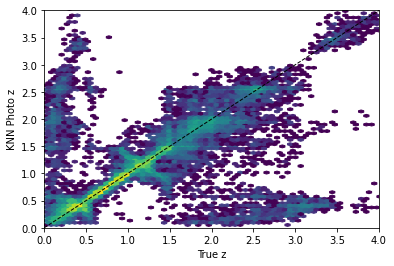

In [43]:
plt.hexbin(truez_LSST, estz_LSST, bins='log')
plt.plot([0,5], [0,5], '--', color='black', linewidth=1)
plt.ylim(0,4)
plt.xlim(0,4)
plt.xlabel("True z")
plt.ylabel("KNN Photo z")
plt.show()

In [26]:
sig = sigma(estz_LSST, truez_LSST, len(estz))

b = bias(estz_LSST, truez_LSST, len(estz))

a_b = abs_bias(estz_LSST, truez_LSST, len(estz))

print(sig, b, a_b)

0.08661546805800022 -0.02219707081091997 0.19770702142503074


In [27]:
sig = sigma(estz_LSST_Castor, truez_LSST_Castor, len(estz))

b = bias(estz_LSST_Castor, truez_LSST_Castor, len(estz))

a_b = abs_bias(estz_LSST_Castor, truez_LSST_Castor, len(estz))

print(sig, b, a_b)

0.04404638715290214 0.0009265921900530586 0.10334875341937617


In [28]:
def error(z_est, z_true, N):
    summand = np.abs(z_est - z_true)
    return summand

In [35]:
Castor_LSST_errors = np.array(error(estz_LSST_Castor, truez_LSST_Castor, len(estz)))
LSST_errors = np.array(error(estz_LSST, truez_LSST, len(estz)))

In [37]:
np.percentile(Castor_LSST_errors, [10, 20, 30, 40, 50, 60, 70, 80, 90])

array([0.00325, 0.00705, 0.0115 , 0.0172 , 0.02465, 0.03505, 0.05188,
       0.0868 , 0.1838 ])

In [38]:
from scipy.stats import percentileofscore

In [50]:
sorted_CASTOR_LSST_errors = np.sort(Castor_LSST_errors)
sorted_LSST_errors = np.sort(LSST_errors)

In [51]:
?np.sort

In [83]:
len(estz)

54469

In [81]:
test["LSST_g_MAG"]

24.873907792253625
24.40528321825905
25.095039038723193
25.08763087666798
23.917503496437213
24.772797990330623
25.546552339809345
22.572196432302384
26.225267571447937
...
24.216276690795205


In [79]:
import astroML

In [128]:
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity


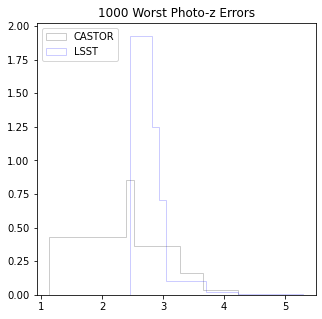

In [136]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.plot(data_array_sorted_CASTOR[-100:,0])

hist(data_array_sorted_CASTOR[-1000:,0], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='k', alpha=0.2,
         label="CASTOR")
hist(data_array_sorted_LSST[-1000:,0], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='b', alpha=0.2,
         label="LSST")

plt.title('1000 Worst Photo-z Errors')

plt.legend()

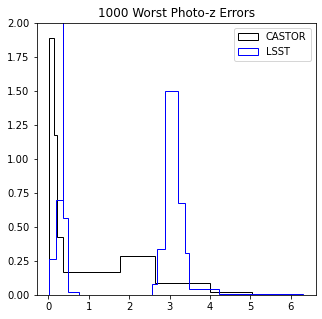

In [137]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.plot(data_array_sorted_CASTOR[-100:,0])

hist(data_array_sorted_CASTOR[-1000:,5], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='k',
         label="CASTOR")
hist(data_array_sorted_LSST[-1000:,5], bins='blocks', ax=ax, density=True, zorder=1,
         histtype='step', color='b',
         label="LSST")

plt.ylim(0, 2)
plt.title('1000 Worst Photo-z Errors')

plt.legend()